# Fisher formalism to forecast biases in parameters.

### Parameters constrained: 6 \$\Lambda{\rm CDM}$ + $\alpha_{\rm radio}$ + $\sigma(\alpha_{\rm radio})$ + $A_{\rm CIB+tSZ}$ + $A_{\rm kSZ}^{h}$ + $\alpha_{\rm kSZ}^{h}$ + $z_{\rm re}^{\rm mid}$ + $\Delta z_{\rm re}$

#### Noise + foreground residuals: tSZ-free x CIB-free cross-ILC from, for example, publish/data/ilc_weights_residuals_agora_fg_model.npy

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np, sys, os, scipy as sc, warnings
sys.path.append('modules/')
import tools, ilc, fisher_tools
import matplotlib.cbook
import scipy.ndimage as ndimage
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

#%pylab notebook
%matplotlib inline
from pylab import *

import copy

In [3]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'


# Get the ILC residuals first

In [4]:
#get the ILC residuals first
which_fg_model = 'agora'

fname = 'publish/ilc/ilc_weights_residuals_%s_fg_model.npy' %(which_fg_model)
ilc_dict = np.load(fname, allow_pickle = True).item()
print(ilc_dict.keys())

#get experiment Nl_dict
nl_TP_dict = ilc_dict['nl_TP_dict']

#different types of ILC considered
ilc_keyname_arr = ilc_dict['ilc_keyname_arr']
print(ilc_keyname_arr)

#ILC weights
weights_dict = ilc_dict['weights']
print(weights_dict.keys())

#total ILC residuals
total_ilc_residuals_dict = ilc_dict['total_ilc_residuals']
print(total_ilc_residuals_dict.keys())

if (1): #with CCAT-prime
    fname_withccatp = 'publish/ilc/ilc_weights_residuals_%s_fg_model_withccatp.npy' %(which_fg_model)
    ilc_dict_withccatp = np.load(fname_withccatp, allow_pickle = True).item()

    weights_dict_withccatp = ilc_dict_withccatp['weights']
    
    #get experiment Nl_dict
    nl_TP_dict_withccatp = ilc_dict_withccatp['nl_TP_dict']

    #total ILC residuals
    total_ilc_residuals_dict_withccatp = ilc_dict_withccatp['total_ilc_residuals']
    #print(total_ilc_residuals_dict.keys())
    
    ##print(ilc_dict_withccatp.keys())

#el range
els = ilc_dict['el']

dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'noise_residuals', 'radio_residuals', 'nl_TP_dict', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])
['mv' 'tszfree' 'cibfree' 'mvxcibfree' 'mvxtszfree' 'tszfreexcibfree']
dict_keys(['s4_wide', 's4_deep', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])
dict_keys(['s4_wide', 's4_deep', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])


# Experiment names and $f_{\rm sky}$ values

In [115]:
#experiment names and fsky values
exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.5, 'black'], 
                  #'s4_wide_withccatp': ['S4-Wide + FYST', 0.57], 
                  's4_deep': ['S4-Ultra Deep', 0.03, 'darkred'], 
                  'spt3g': ['SPT-3G', 0.03, 'darkgreen'],
                  'spt4': ['SPT-3G+SPT-4', 0.03, 'tab:green'],
                  'so_baseline': ['SO-Baseline', 0.4, 'royalblue'],
                  'so_baseline_withccatp': ['SO-Baseline + FYST', 0.4, 'tab:blue'], 
                  'so_goal': ['SO-Goal', 0.4, 'darkorange'],
                  'so_goal_withccatp': ['SO-Goal + FYST', 0.4, 'tab:orange'], 
                  }

exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.5, 'black'], 
                  's4_deep': ['S4-Ultra Deep', 0.03, 'darkred'], 
                  'spt3g': ['SPT-3G', 0.03, 'darkgreen'],
                  'spt4': ['SPT-3G w/ SPT-4', 0.03, 'goldenrod'],
                  'so_baseline': ['SO-Baseline', 0.4, 'royalblue'],
                  'so_baseline_withccatp': ['SO-Baseline w/  FYST', 0.4, 'blue'], 
                  'so_goal': ['SO-Goal', 0.4, 'darkorange'],
                  'so_goal_withccatp': ['SO-Goal w/  FYST', 0.4, 'chocolate'], 
                  }

#ILC keynames
ilc_keyname_dict = {'mv':'MV', 'tszfree': 'tSZ-free', 'cibfree': 'CIB-free'}

# Setting variables for Fisher forecasting
### Default cosmology: $\texttt{planck_cosmo_version}$ = ${\it Planck}$ 2018.
  * ### Param file used for CAMB: publish/data/params_planck_r_0.0_2018_cosmo.txt
  * ### TT, TE, EE + lowE + lensing in Table 2 of [1807.06209](https://arxiv.org/abs/1807.06209)
  * ### ${\it Planck}$ 2015 is also available.
  * ### Radio residuals are modelled using two parameters:
      * #### $\alpha_{\rm rad} = -0.76$: Mean spectral index of sources.
      * #### $\sigma(\alpha_{\rm rad}) = 0.2$: Scatter in the spectral index of sources.
  * ### Left over CIB+tSZ residuals are modelled using a single amplitude parameter $A_{\rm CIB+tSZ}=1$.

In [116]:
#some variables for Fisher forecasting
#expname = 's4_wide'
#fsky = exp_specs_dict[expname][1]
planck_cosmo_version = 2018 ##2015 #2018
camb_folder = 'publish/data/CAMB/planck_%s/' %(planck_cosmo_version)
which_spectra = 'lensed'
#which_spectra = 'unlensed'
reqd_ilc_keyname_1 = 'tszfree'
reqd_ilc_keyname_2 = 'cibfree'
max_flux_mJy = 3e-3 #masking threshold used.
if reqd_ilc_keyname_1 != reqd_ilc_keyname_2:
    reqd_ilc_keyname_12 = '%sx%s' %(reqd_ilc_keyname_1, reqd_ilc_keyname_2)
else:
    reqd_ilc_keyname_12 = reqd_ilc_keyname_1

#radio-related stuffs
spec_index_radio = -0.76 #Radio spectral index fiducial value
spec_index_radio_step = spec_index_radio/100. #stpe for derivative calculation
spec_index_radio_prior = 0.1 #Radio spectral index prior
alpha_radio = spec_index_radio

spec_index_radio_scatter = 0.2 #Radio spectral index fiducial scatter
spec_index_radio_scatter_step = spec_index_radio_scatter/100.
spec_index_radio_scatter_prior = 0.3 #Radio spectral index scatter prior
alpha_radio_sigma = spec_index_radio_scatter

#CIB+tSZ residuals
Acibtsz = 1.
Acibtsz_step = Acibtsz/100.

## Pick CMB $C_{\ell}^{\rm xx}$ and derivatives $\dfrac{\partial C_{\ell}^{\rm XX}}{\partial \theta}$ where ${\rm XX} \in [TT, EE, TE]$ and $\theta \in [A_{s},\ h,\ n_{s},\ \Omega_{c}h^{2},\ \Omega_{b}h^{2},\ \tau_{\rm re}]$
### Note:
* $C_{\ell}$ and the derivatives are already stored and also contain additional parameters namely $\sum m_{\nu}$ and $w_{0}$. Both these parameters are fixed during Fisher forecasting.
* Paramters that are added later (below):
  * $A_{\rm kSZ}$ - Amplitude of the kSZ power spectrum $D_{\ell} = 3 \mu {\rm K}^{2}$.
  * $\alpha_{\rm rad}$ - Spectral index of radio point sources.
  * $\sigma(\alpha_{\rm rad})$ - Scatter in the distribution of spectral indices of the radio point sources.

In [117]:
#CMB stuffs
#get fiducual LCDM power spectra computed using CAMB
import copy
print('get fiducual LCDM power spectra computed using CAMB')
camb_fname = '%s/cmb_spectra_%s.txt' %(camb_folder, which_spectra)
print(camb_fname)
cl_camb = np.loadtxt(camb_fname)
el_camb = cl_camb[:,0] 
cl_camb_tt = cl_camb[:,1]
dl_fac_camb = el_camb * (el_camb+1)/2/np.pi
cl_dic = {}
cl_dic['TT'] = cl_camb[:,1]
cl_dic['EE'] = cl_camb[:,2]
cl_dic['TE'] = cl_camb[:,3]

if (0):
    ax  =subplot(111, yscale = 'log')
    plot(el_camb, cl_dic['TT'], color = 'black')
    xlim(0., 5000.); ylim(1e-8, 1e-2); 
    show(); sys.exit()

#get derivatives of CMB power spectrum for different LCDM parameters.
#They are already computed and stored.
print('get/read derivatives')
camb_deriv_fname = '%s/cmb_spectra_derivs_%s.npy' %(camb_folder, which_spectra)
cl_deriv_dic_tmp = np.load(camb_deriv_fname, allow_pickle = 1).item()
cl_deriv_dic = {}
param_names = []
for p in sorted( cl_deriv_dic_tmp ):
    if p == 'ell': continue    
    cl_deriv_dic[p]={}
    if planck_cosmo_version == 2018:
        cl_deriv_dic[p]['TT'] = cl_deriv_dic_tmp[p]['TT']
        cl_deriv_dic[p]['EE'] = cl_deriv_dic_tmp[p]['EE']
        cl_deriv_dic[p]['TE'] = cl_deriv_dic_tmp[p]['TE']
    else:
        cl_deriv_dic[p]['TT'] = cl_deriv_dic_tmp[p][0]
        cl_deriv_dic[p]['EE'] = cl_deriv_dic_tmp[p][1]
        cl_deriv_dic[p]['TE'] = cl_deriv_dic_tmp[p][2]
    
    if p == 'As' and planck_cosmo_version == 2015:
        cl_deriv_dic[p]['TT'] *= 1e9
        cl_deriv_dic[p]['EE'] *= 1e9
        cl_deriv_dic[p]['TE'] *= 1e9
        
    param_names.append( p )
    
#interpolate CAMB spectra / derivatives on the desired els.
for which_spec in cl_dic:
    cl_dic[which_spec] = np.interp(els, el_camb, cl_dic[which_spec], right=0.)
for p in sorted( param_names ):
    for which_spec in cl_deriv_dic[p]:
        cl_deriv_dic[p][which_spec] = np.interp(els, el_camb, cl_deriv_dic[p][which_spec], right=0.)
        
cl_dic_cmb = copy.deepcopy(cl_dic)

get fiducual LCDM power spectra computed using CAMB
publish/data/CAMB/planck_2018//cmb_spectra_lensed.txt
get/read derivatives


In [118]:
#kSZ stuffs

#ksz-related stuffs.    
redo_fisher = False

#parameters for total kSZ SNR
dl_ksz_amp_total = 3. #D_{\ell}^{\rm kSZ} = 3 uK^2 
Aksz = 1. #Amplitude of kSZ.
Aksz_step = Aksz / 100. #stpe for derivative calculation

#parameters for homogeneous and reionisation kSZ.
#homogeneous kSZ - similar to Alvarez et al. 2020
Aksz_h = 1.5
alphaksz_h = 0.
Aksz_h_step = Aksz_h/100.
alphaksz_h_step = 0.01

#patchy kSZ part
##zmid = 8.
import tools_for_plotting
import camb
param_dict = tools_for_plotting.get_ini_param_dict()
#print(param_dict)
pars = camb.CAMBparams(max_l_tensor = param_dict['max_l_tensor'], max_eta_k_tensor = param_dict['max_eta_k_tensor'])
pars.set_accuracy(AccuracyBoost = param_dict['AccuracyBoost'], lAccuracyBoost = param_dict['lAccuracyBoost'], lSampleBoost = param_dict['lSampleBoost'],\
    DoLateRadTruncation = param_dict['do_late_rad_truncation'])
pars.set_cosmology(thetastar=param_dict['thetastar'], ombh2=param_dict['ombh2'], omch2=param_dict['omch2'], nnu = param_dict['neff'], mnu=param_dict['mnu'], \
    omk=param_dict['omk'], tau=param_dict['tau'], YHe = param_dict['YHe'], Alens = param_dict['Alens'], \
    num_massive_neutrinos = param_dict['num_nu_massive'])

zmid = camb.get_zre_from_tau(pars,param_dict['tau'])
zdur = 4.
if (0): #precomputed.
    zmid_step = zmid/100.
    zdur_step = zdur/100.

print('get kSZ spectrum and derivatives')
"""
Assumptions:
1. We assume that the derivatives of cl_kSZ w.r.t LCDM parameters is zero.
    (A) This is not 100 per cent true.
2. We also assume that the derivatives of CMB power spectrum w.r.t AkSZ is zero.
    (A) This is a reasonable assumption.
"""

#get kSZ spectrum now: Flat D_{\ell}^{\rm kSZ} = 3 uK^2 
cl_ksz = fisher_tools.get_cl_ksz(els, Aksz = Aksz, dl_ksz_amp_total = dl_ksz_amp_total)

#add kSZ to cl_dic['TT']
cl_dic['TT'] += cl_ksz

#get deriviatives for Aksz
cl_ksz_low = fisher_tools.get_cl_ksz(els, Aksz = Aksz - Aksz_step, dl_ksz_amp_total = dl_ksz_amp_total)
cl_ksz_high = fisher_tools.get_cl_ksz(els, Aksz = Aksz + Aksz_step, dl_ksz_amp_total = dl_ksz_amp_total)
cl_deriv_dic['Aksz'] = {}
cl_deriv_dic['Aksz']['TT'] = (cl_ksz_high-cl_ksz_low)/( 2 * Aksz_step)
cl_deriv_dic['Aksz']['EE'] = cl_deriv_dic['Aksz']['TT'] * 0.
cl_deriv_dic['Aksz']['TE'] = cl_deriv_dic['Aksz']['TT'] * 0.

#get homogeneous kSZ first
el_norm = 3000.
cl_ksz_homo = fisher_tools.get_homo_ksz(els, Aksz_h = Aksz_h, alphaksz_h = alphaksz_h, el_norm = el_norm)
#add cl_ksz_homo to cl_dic['TT']
cl_dic['TT'] += cl_ksz_homo
#get derivatives
#Aksz_h first
cl_ksz_homo_low = fisher_tools.get_homo_ksz(els, Aksz_h = Aksz_h - Aksz_h_step, alphaksz_h = alphaksz_h, el_norm = el_norm)
cl_ksz_homo_high = fisher_tools.get_homo_ksz(els, Aksz_h = Aksz_h + Aksz_h_step, alphaksz_h = alphaksz_h, el_norm = el_norm)
cl_deriv_dic['Aksz_h'] = {}
cl_deriv_dic['Aksz_h']['TT'] = (cl_ksz_homo_high-cl_ksz_homo_low)/( 2 * Aksz_h_step)
cl_deriv_dic['Aksz_h']['EE'] = cl_deriv_dic['Aksz_h']['TT'] * 0.
cl_deriv_dic['Aksz_h']['TE'] = cl_deriv_dic['Aksz_h']['TT'] * 0.
#alphaksz_h now
cl_ksz_homo_low = fisher_tools.get_homo_ksz(els, Aksz_h = Aksz_h, alphaksz_h = alphaksz_h - alphaksz_h_step, el_norm = el_norm)
cl_ksz_homo_high = fisher_tools.get_homo_ksz(els, Aksz_h = Aksz_h, alphaksz_h = alphaksz_h + alphaksz_h_step, el_norm = el_norm)
cl_deriv_dic['alphaksz_h'] = {}
cl_deriv_dic['alphaksz_h']['TT'] = (cl_ksz_homo_high-cl_ksz_homo_low)/( 2 * alphaksz_h_step)
cl_deriv_dic['alphaksz_h']['EE'] = cl_deriv_dic['alphaksz_h']['TT'] * 0.
cl_deriv_dic['alphaksz_h']['TE'] = cl_deriv_dic['alphaksz_h']['TT'] * 0.

#get patchy kSZ now (from precomputed file.)
patchy_ksz_fname = 'publish/data/cl_patchy_ksz_amber_derivatives.npy'
patchy_ksz_dict = np.load(patchy_ksz_fname, allow_pickle = True).item()
els_, cl_ksz_patchy = patchy_ksz_dict['els'], patchy_ksz_dict['cl_ksz_patchy']
cl_ksz_patchy = np.interp(els, els_, cl_ksz_patchy)
#add cl_ksz_patchy to cl_dic['TT']
cl_dic['TT'] += cl_ksz_patchy

if (0):
    dl_fac = els * (els+1)/2/np.pi
    ax = subplot(111, yscale='log')
    plot(els, dl_fac * cl_dic_cmb['TT'], color = 'gray')
    plot(els, dl_fac * cl_ksz_homo, color = 'orangered')
    plot(els, dl_fac * cl_ksz_patchy, color = 'goldenrod')
    plot(els, dl_fac * cl_dic['TT'], color = 'black')
    xlim(0., 5000.); ylim(0.1, 1e4)
    show(); sys.exit()

#derivatives
cl_ksz_patchy_deriv = patchy_ksz_dict['cl_ksz_patchy_deriv']
for tmp_p in cl_ksz_patchy_deriv:
    curr_cl_ksz_patchy_deriv = cl_ksz_patchy_deriv[tmp_p]
    curr_cl_ksz_patchy_deriv = np.interp(els, els_, curr_cl_ksz_patchy_deriv)
    cl_deriv_dic[tmp_p] = {}
    cl_deriv_dic[tmp_p]['TT'] = curr_cl_ksz_patchy_deriv
    cl_deriv_dic[tmp_p]['EE'] = curr_cl_ksz_patchy_deriv * 0.
    cl_deriv_dic[tmp_p]['TE'] = curr_cl_ksz_patchy_deriv * 0.

#store this in a different dict for future use.
#We will add experiment dependent radio residuals below which will change this dictionary.
cl_dic_ori = copy.deepcopy(cl_dic)
cl_deriv_dic_ori = copy.deepcopy(cl_deriv_dic)

print(cl_deriv_dic_ori.keys())

get kSZ spectrum and derivatives
dict_keys(['As', 'mnu', 'neff', 'ns', 'ombh2', 'omch2', 'tau', 'thetastar', 'ws', 'Aksz', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur'])


In [119]:
#details about the precomputed Fisher matrix
total_ksz_fisher_fname = 'publish/fisher/F_mat_lcdm_foregrounds_allkSZ_TTEETE_3mJymask.npy'
reqd_lmax_tt = 5000
maxltempkeyname = 'lmax_%s' %(reqd_lmax_tt)
reqd_F_dic = np.load(total_ksz_fisher_fname, allow_pickle=True).item()[maxltempkeyname]
reqd_lmax_tt_ksz_arr = [3000, 3500, 4000, 4500, 5000]

In [120]:
#parameters for bias calculations.
cib_tsz_res_sys = 0.05 ##0.2
ilcname_arr = ['MV', 'cross-ILC']
#ilcname_arr = ['cross-ILC']
desired_param = 'Aksz'
fix_params_arr = ['mnu', 'ws', 'neff', 'alpha_radio', 'alpha_radio_sigma', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur', 'Acibtsz']

#priors
tau_prior_litebird = 0.002
spec_index_radio_prior = 0.1 #Radio spectral index prior
spec_index_radio_scatter_prior = 0.3 #Radio spectral index scatter prior
Aksz_h_prior = 0.1
alphaksz_h_prior = 0.1
Acibtsz_prior = 0.1
prior_dic = {'tau':0.007}#, 'Acibtsz_prior': Acibtsz_prior}# #Planck tau prior

reqd_expname = None
sys_level_interms_of_sigma = None
if (0):
    reqd_expname = 'spt3g'
    ##reqd_expname = 's4_wide'
    ##reqd_lmax_tt_ksz_arr = [3000, 3500, 4000, 4500, 5000]
    reqd_lmax_tt_ksz_arr = [5000]
    ilcname_arr = ['MV', 'cross-ILC']
    #ilcname_arr = ['MV']
    sys_level_interms_of_sigma = 3.6
    sys_bias_param_name_arr = ['Aksz']
    

In [121]:
#read Fisher, add bias, and estimate bias using Fisher formalism
debug = False ##True #False #True #False ##False
tmp_color_dict = {'TT': 'black', 'EE': 'orangered', 'TE': 'goldenrod'}

bias_dic_for_plotting = {}
for expname in reqd_F_dic:
    if reqd_expname is not None and expname != reqd_expname: continue
    bias_dic_for_plotting[expname] = {}
    if debug and expname != reqd_expname: continue
    print('\nExperiment = %s' %(expname))
    latex_str = ''
    for ilcname in ilcname_arr:
        bias_dic_for_plotting[expname][ilcname] = {}
        if debug:
            clf()
            ax = subplot(111, yscale = 'log')
            for which_spec in ['TT', 'EE', 'TE']:
                plot(els, dl_fac * cl_dic[which_spec], color = tmp_color_dict[which_spec], lw = 2.)
                plot(els, dl_fac * -cl_dic[which_spec], color = tmp_color_dict[which_spec], lw = 4., alpha = 0.2)
        for tmplmaxcntr, reqd_lmax_tt_ksz in enumerate( reqd_lmax_tt_ksz_arr ):
            keyname = (reqd_lmax_tt_ksz, reqd_lmax_tt)
            if keyname not in reqd_F_dic[expname][ilcname]: continue

            #Fisher matrix.
            tmp_F_mat, tmp_param_names = reqd_F_dic[expname][ilcname][keyname]

            #add priors.
            tmp_F_mat = fisher_tools.add_priors(tmp_F_mat, tmp_param_names, prior_dic)
            
            if sys_level_interms_of_sigma is not None: #remove me
                fix_params_arr = np.copy(tmp_param_names).tolist()
                for tmpppp in sys_bias_param_name_arr:
                    if tmpppp in fix_params_arr: fix_params_arr.remove(tmpppp)
            
            #fix desired parameters.
            tmp_F_mat, tmp_param_names = fisher_tools.fix_params(tmp_F_mat, tmp_param_names, fix_params_arr)
            
            ##print(expname, tmp_F_mat.shape, tmp_param_names); sys.exit()

            #bias related stuff
            cl_dic_forthisexp = copy.deepcopy(cl_dic_ori)
            cl_deriv_dic_forthisexp = copy.deepcopy(cl_deriv_dic_ori)

            ##print(cl_deriv_dic_forthisexp.keys()); sys.exit()

            #get experiment-dependent CIB+tSZ stuffs
            if ilcname == 'cross-ILC':
                reqd_ilc_keyname_1 = 'tszfree'
                reqd_ilc_keyname_2 = 'cibfree'
            else:
                reqd_ilc_keyname_1 = reqd_ilc_keyname_2 = 'mv'

            if reqd_ilc_keyname_1 != reqd_ilc_keyname_2:
                reqd_ilc_keyname_12 = '%sx%s' %(reqd_ilc_keyname_1, reqd_ilc_keyname_2)
            else:
                reqd_ilc_keyname_12 = reqd_ilc_keyname_1

            cl_cib_tsz, cl_dic_forthisexp, cl_deriv_dic_forthisexp = tools.get_cib_tsz_spectrum_and_derivatives(els, expname, cl_dic_forthisexp, cl_deriv_dic_forthisexp, 
                                                                                                          reqd_ilc_keyname_1, reqd_ilc_keyname_2 = reqd_ilc_keyname_2, 
                                                                                                          Acibtsz = Acibtsz, Acibtsz_step = Acibtsz_step)

            cl_shift = np.copy(cl_cib_tsz) * cib_tsz_res_sys
            cl_deriv_dic_forthisexp['Aksz']['TT'][reqd_lmax_tt_ksz:] = 0.
            ###cl_shift[:2000] = 0.
            if (0):##ilcname == 'MV':
                cl_cib_tsz = 3./dl_fac**0.7 #remove me
                
            if sys_level_interms_of_sigma is not None: #add xx per cent of kSZ SNR as the systematic error - remove me later.
                sigma_Aksz = fisher_tools.get_sigma_of_a_parameter(tmp_F_mat, tmp_param_names, desired_param, prior_dic = prior_dic, fix_params_arr = fix_params_arr)
                shift_val = sigma_Aksz * sys_level_interms_of_sigma
                Aksz_mod = Aksz + shift_val
                cl_tmp_fid = fisher_tools.get_cl_ksz(els)
                cl_tmp_mod = fisher_tools.get_cl_ksz(els, Aksz = Aksz_mod)
                cl_shift = cl_tmp_fid - cl_tmp_mod
                cl_dic_forthisexp['TT'] = cl_dic_forthisexp['TT'] - cl_cib_tsz# + cl_shift

            cl_sys_dic = {}
            cl_sys_dic['TT'] = cl_shift
            cl_sys_dic['EE'] = np.zeros_like(cl_shift) #cl_shift * 0.01 #np.zeros_like(cl_cib_tsz)
            cl_sys_dic['TE'] = np.zeros_like(cl_shift)

            bands = tools.get_exp_bands(expname)

            #get MV polarisation ILC residuals
            els, mvilc_pol_residuals = tools.get_polarisation_mvilc_residuals(els, expname)
            dl_fac = els * (els+1)/2/np.pi

            #get temperature ILC residuals
            els, total_ilc_residual_mv, total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12 = tools.get_temperature_ilc_residuals(expname, reqd_ilc_keyname_1, reqd_ilc_keyname_2, quiet = True)
            '''
            print(total_ilc_residual_mv)
            print(total_ilc_residual_1)
            print(total_ilc_residual_2)
            print(total_ilc_residual_12)
            '''

            cl_dic_mod = {}
            for which_spec in cl_dic_forthisexp:
                cl_dic_mod[which_spec] = cl_dic_forthisexp[which_spec] - cl_sys_dic[which_spec]

            expname_str, fsky, colorval = exp_specs_dict[expname]
            delta_cl_dic, delta_cl_dic_mv = tools.wrapper_get_delta_cl(els, cl_dic_mod, fsky, 
                                    total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12, 
                                    total_ilc_residual_mv, mvilc_pol_residuals,
                                   )

            if debug:#reqd_lmax_tt_ksz == 5000:
                for which_spec in ['TT', 'EE', 'TE']:
                    plot(els, dl_fac * cl_sys_dic[which_spec], color = tmp_color_dict[which_spec], lw = 0.5)
                    plot(els, dl_fac * -cl_sys_dic[which_spec], color = tmp_color_dict[which_spec], lw = 0.5, alpha = 0.2)
                axhline(3., lw = 1.)
                xlim(0., 5000.); ylim(1e-4, 6e3); title(r'%s' %(ilcname))
                ##show(); sys.exit()
                    
            final_bias_vector = fisher_tools.get_bias_vector(els, tmp_F_mat, tmp_param_names, delta_cl_dic, cl_deriv_dic_forthisexp, cl_sys_dic, max_l = reqd_lmax_tt_ksz)
            
            pind = np.where(tmp_param_names == desired_param)
            sys_sigma_Aksz = final_bias_vector[pind]
            sigma_Aksz = fisher_tools.get_sigma_of_a_parameter(tmp_F_mat, tmp_param_names, desired_param, prior_dic = prior_dic, fix_params_arr = fix_params_arr)
            #print(sigma_Aksz)
            Aksz_bias_over_error = sys_sigma_Aksz / sigma_Aksz
            ##print(tmp_F_mat.shape, tmp_param_names, sigma_Aksz)
            snr_Aksz = Aksz/sigma_Aksz
            if sys_level_interms_of_sigma is not None:
                print( '\t\tILC=%s; lmax=%s; SNR=%.2f; sigma=%.3f; Input bias = %g; Recovered bias=%g; Bias/sigma=%.2f' %(ilcname, reqd_lmax_tt_ksz, snr_Aksz, sigma_Aksz, shift_val, sys_sigma_Aksz, Aksz_bias_over_error) )
            else:
                print( '\t\tILC=%s; lmax=%s; SNR=%.2f; sigma=%.3f; Recovered bias=%g; Bias/sigma=%.2f' %(ilcname, reqd_lmax_tt_ksz, snr_Aksz, sigma_Aksz, sys_sigma_Aksz, Aksz_bias_over_error) )
            bias_dic_for_plotting[expname][ilcname][reqd_lmax_tt_ksz] = [tmp_F_mat, tmp_param_names, final_bias_vector, snr_Aksz, sigma_Aksz, sys_sigma_Aksz, Aksz_bias_over_error]
            latex_str = '%s & %.2f' %(latex_str, snr_Aksz); #sys.exit()
        if debug: show(); #sys.exit()
    ##print('\t', latex_str);
    ###sys.exit()            


Experiment = spt3g
		ILC=MV; lmax=3000; SNR=10.36; sigma=0.097; Recovered bias=0.099422; Bias/sigma=1.03
		ILC=MV; lmax=3500; SNR=19.78; sigma=0.051; Recovered bias=0.103305; Bias/sigma=2.04
		ILC=MV; lmax=4000; SNR=29.33; sigma=0.034; Recovered bias=0.105786; Bias/sigma=3.10
		ILC=MV; lmax=4500; SNR=36.31; sigma=0.028; Recovered bias=0.109042; Bias/sigma=3.96
		ILC=MV; lmax=5000; SNR=41.54; sigma=0.024; Recovered bias=0.112051; Bias/sigma=4.65
		ILC=cross-ILC; lmax=3000; SNR=8.55; sigma=0.117; Recovered bias=-0.0133314; Bias/sigma=-0.11
		ILC=cross-ILC; lmax=3500; SNR=13.33; sigma=0.075; Recovered bias=-0.00907756; Bias/sigma=-0.12
		ILC=cross-ILC; lmax=4000; SNR=16.93; sigma=0.059; Recovered bias=-0.00602833; Bias/sigma=-0.10
		ILC=cross-ILC; lmax=4500; SNR=19.41; sigma=0.052; Recovered bias=-0.00429601; Bias/sigma=-0.08
		ILC=cross-ILC; lmax=5000; SNR=21.12; sigma=0.047; Recovered bias=-0.00362544; Bias/sigma=-0.08

Experiment = spt4
		ILC=MV; lmax=3000; SNR=11.54; sigma=0.087; Rec

1 As As 7 As ns 13 As ombh2 19 As omch2 25 As tau 31 As Aksz 8 ns ns 14 ns ombh2 20 ns omch2 26 ns tau 32 ns Aksz 15 ombh2 ombh2 21 ombh2 omch2 27 ombh2 tau 33 ombh2 Aksz 22 omch2 omch2 28 omch2 tau 34 omch2 Aksz 29 tau tau 35 tau Aksz 36 Aksz Aksz 6 6
1 As As 7 As ns 13 As ombh2 19 As omch2 25 As tau 31 As Aksz 8 ns ns 14 ns ombh2 20 ns omch2 26 ns tau 32 ns Aksz 15 ombh2 ombh2 21 ombh2 omch2 27 ombh2 tau 33 ombh2 Aksz 22 omch2 omch2 28 omch2 tau 34 omch2 Aksz 29 tau tau 35 tau Aksz 36 Aksz Aksz 6 6


<Figure size 900x600 with 0 Axes>

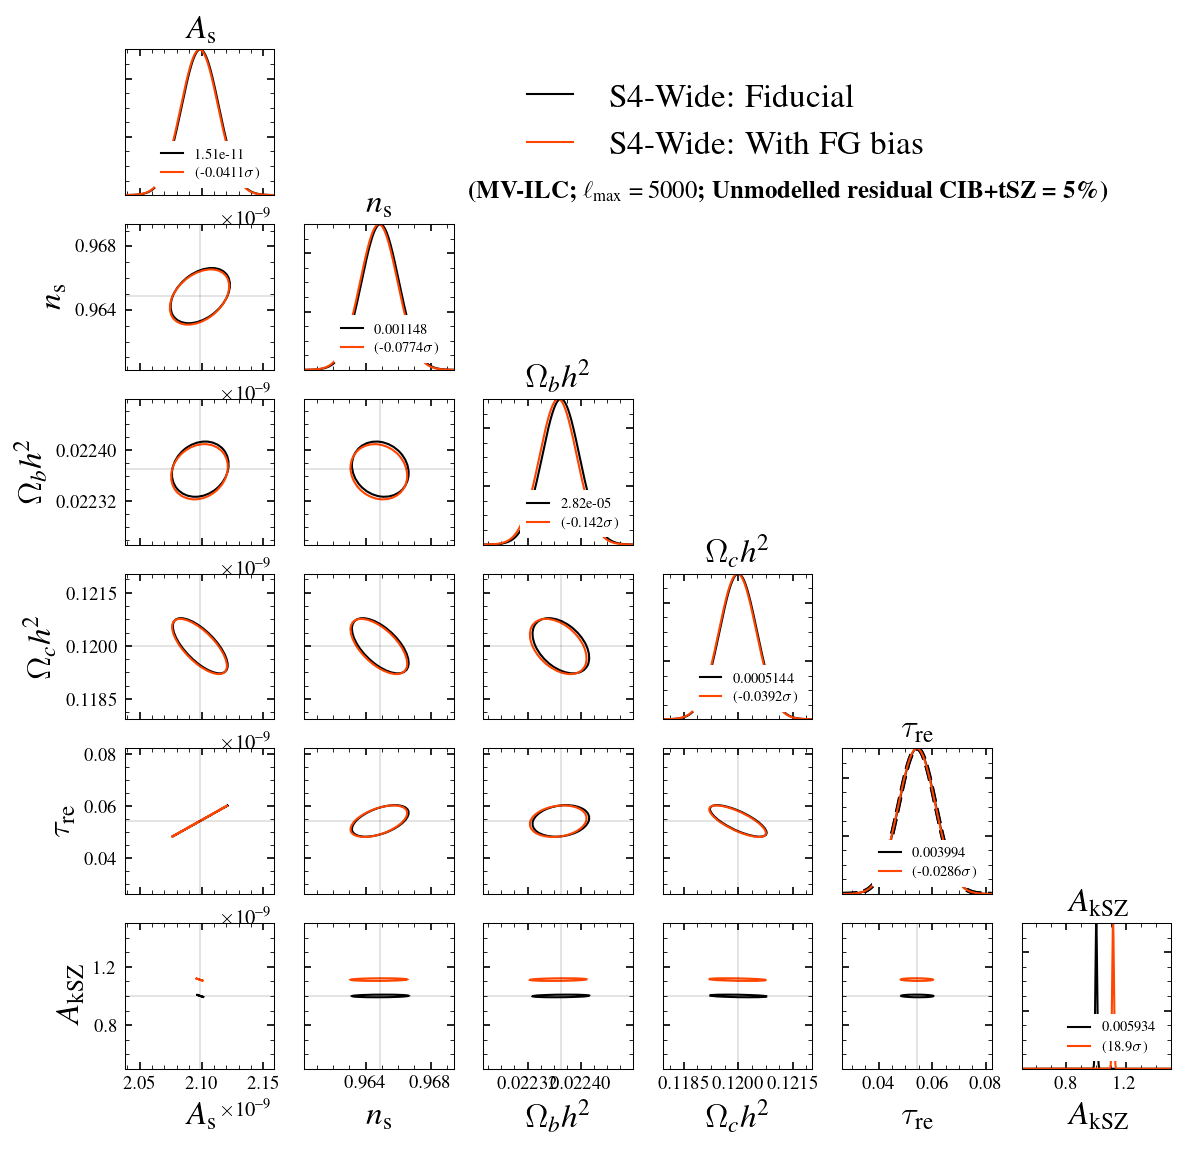

1 As As 7 As ns 13 As ombh2 19 As omch2 25 As tau 31 As Aksz 8 ns ns 14 ns ombh2 20 ns omch2 26 ns tau 32 ns Aksz 15 ombh2 ombh2 21 ombh2 omch2 27 ombh2 tau 33 ombh2 Aksz 22 omch2 omch2 28 omch2 tau 34 omch2 Aksz 29 tau tau 35 tau Aksz 36 Aksz Aksz 6 6
1 As As 7 As ns 13 As ombh2 19 As omch2 25 As tau 31 As Aksz 8 ns ns 14 ns ombh2 20 ns omch2 26 ns tau 32 ns Aksz 15 ombh2 ombh2 21 ombh2 omch2 27 ombh2 tau 33 ombh2 Aksz 22 omch2 omch2 28 omch2 tau 34 omch2 Aksz 29 tau tau 35 tau Aksz 36 Aksz Aksz 6 6


<Figure size 900x600 with 0 Axes>

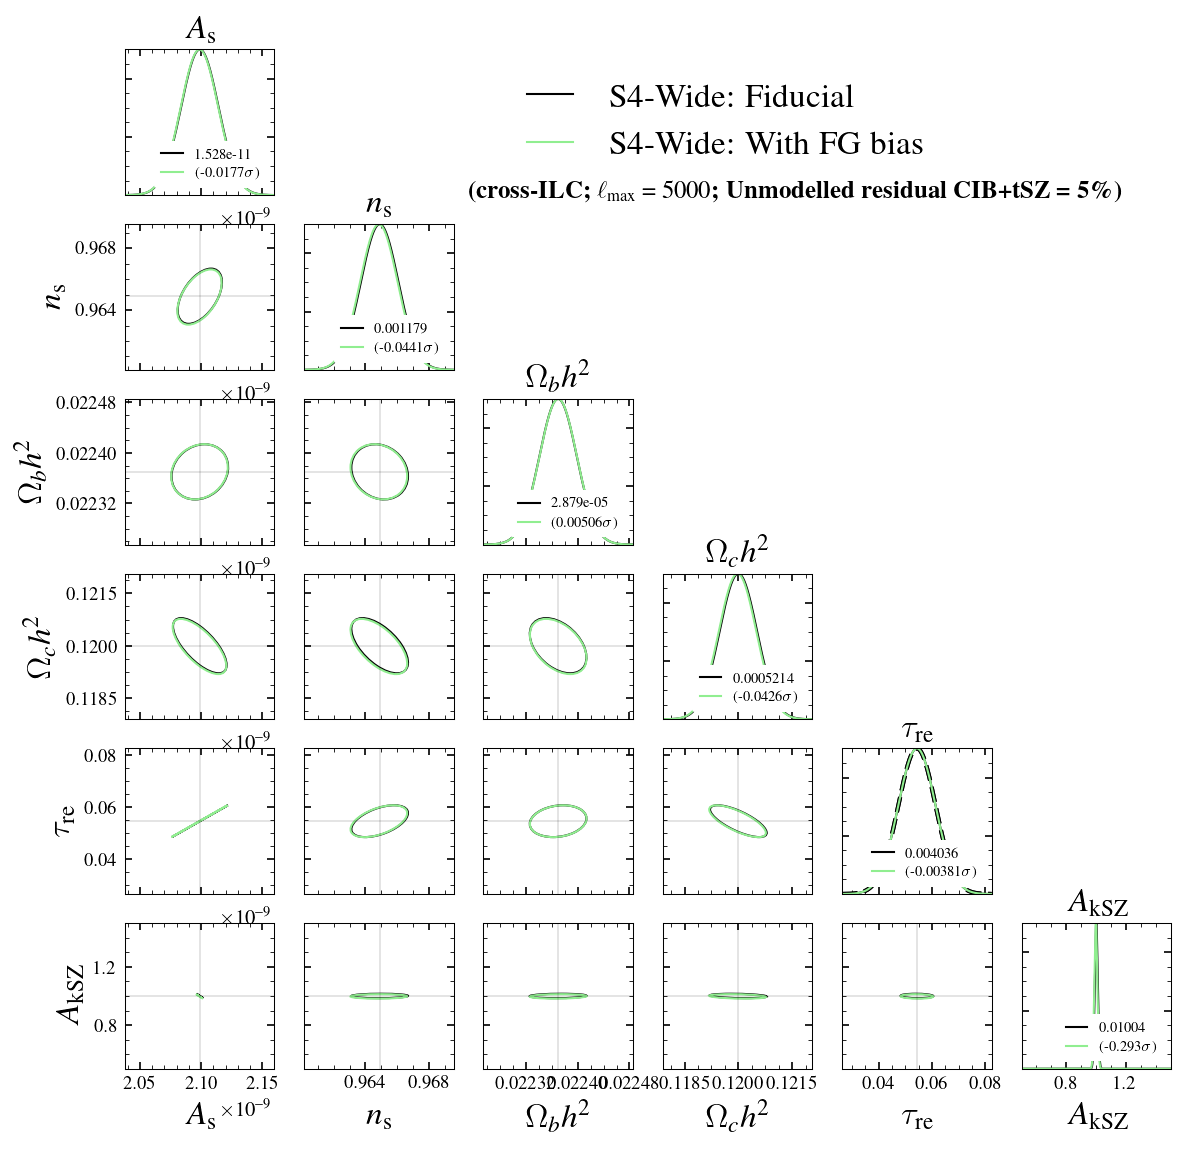

In [122]:
#make a corner plot now
for reqd_ilcname in ilcname_arr:
    if reqd_expname is None:
        reqd_expname = 's4_wide'
    reqd_expname = reqd_expname #expname #'s4_wide'
    #reqd_ilcname = 'MV'
    reqd_lmax_tt_ksz = 5000

    F_mat_mod, param_names_mod, final_bias_vector, snr_Aksz, sigma_Aksz, sys_sigma_Aksz, Aksz_bias_over_error = bias_dic_for_plotting[reqd_expname][reqd_ilcname][reqd_lmax_tt_ksz]

    expname_arr = ['Fiducial', 'With FG bias']
    #desired_params_to_plot = [sys_bias_param_name]
    desired_params_to_plot = np.copy(param_names_mod).tolist()
    desired_params_to_plot.remove('thetastar')
    '''
    for ppp in fix_params_arr:
        if ppp in desired_params_to_plot:
            desired_params_to_plot.remove(ppp)
    ##desired_params_to_plot = desired_params_to_plot[0:4]
    '''
    #desired_params_to_plot = ['Aksz']
    #print(desired_params_to_plot); sys.exit()
    tr = tc = len(desired_params_to_plot)
    if reqd_ilcname == 'MV':
        color_arr = ['black', 'orangered']
    else:
        color_arr = ['black', 'lightgreen']
    fsval = 12
    clf()
    if len(desired_params_to_plot)>4:
        fig = figure(figsize = (tr+3, tc+3))
    for iter, expname in enumerate( expname_arr ): 
        bias_dic = None
        param_dict_mod = copy.deepcopy( param_dict )
        if iter == 0:
            curr_final_bias_vector = np.zeros_like(final_bias_vector)        
        else:
            curr_final_bias_vector = np.copy(final_bias_vector)

        for pind, p in enumerate( param_names_mod ):
            param_dict_mod[p] = param_dict_mod[p] + curr_final_bias_vector[pind]

        if iter == 1:
            bias_dic = {}
            for pind, p in enumerate( param_names_mod ):
                shifted_val = param_dict[p] - curr_final_bias_vector[pind]
                bias_dic[p] = [shifted_val, curr_final_bias_vector[pind]]

        F_dic = {}
        F_dic[expname] = F_mat_mod

        color_dic = {}
        color_dic[expname] = [color_arr[iter]]

        fix_axis_range_to_xxsigma = 4.
        tr, tc = tools_for_plotting.make_triangle_plot([expname], F_dic, param_dict_mod, param_names_mod, desired_params_to_plot, color_dic, ls_dic = None, one_or_two_sigma = 1, fsval = fsval, prior_dic = prior_dic, bias_dic = bias_dic, fix_axis_range_to_xxsigma = fix_axis_range_to_xxsigma)
        print(tr, tc)
    #show(); sys.exit()

    if len(desired_params_to_plot) == 1:
        tmpppp = desired_params_to_plot[0]
        stat_sigma = fisher_tools.get_sigma_of_a_parameter(F_mat_mod, param_names_mod, tmpppp, prior_dic = prior_dic, fix_params_arr = fix_params_arr)
        axvline(param_dict[tmpppp], color = 'black', ls = '--', label = 'Fiducial: %g' %(param_dict[tmpppp]))
        xlabel(r'%s' %(tools_for_plotting.get_latex_param_str(tmpppp)), fontsize = 14)
        legend(loc = 'best', fontsize = 8)
        xval = param_dict[tmpppp]
        x1, x2 = xval - stat_sigma * 50., xval + stat_sigma * 50.
        xlim(x1, x2)
        print(x1, x2)
    else:
        if tr > 2:
            ax = subplot(tr, tc, 3)
        else:
            ax = subplot(tr, tc, 2)    
        for tmpnamecntr, expname in enumerate( expname_arr ):
            plot([], [], color = color_arr[tmpnamecntr], label = r'%s: %s' %(exp_specs_dict[reqd_expname][0], expname))
            
        reqd_ilcname_str = '%s-ILC' %(reqd_ilcname)
        reqd_ilcname_str = reqd_ilcname_str.replace('-ILC-ILC', '-ILC')

        textval = r'{\bf (%s; $\ell_{\rm max} = %s$; Unmodelled residual CIB+tSZ = %g\%%)}' %(reqd_ilcname_str, reqd_lmax_tt_ksz, cib_tsz_res_sys * 100.)
        figtext(0.38, 0.77, textval, fontsize = 12)
        legend(loc = 2, fontsize = 16, framealpha = 0.)
        axis('off')    
    show()


SystemExit: 

<Figure size 900x600 with 0 Axes>

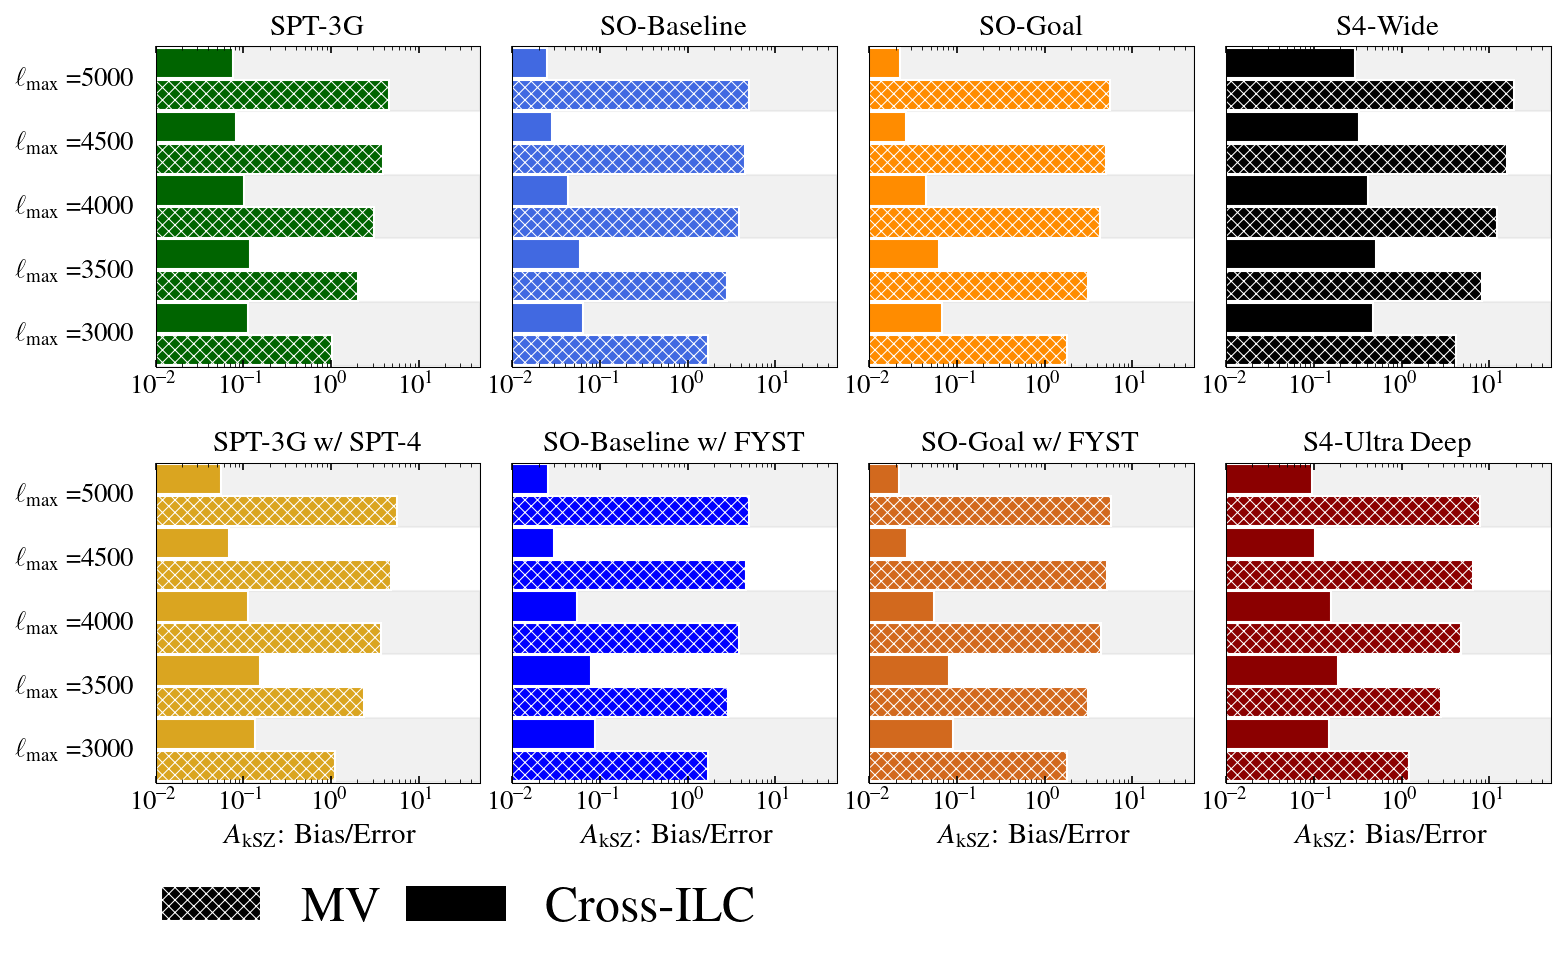

In [180]:
def fn_format_axis(ax,fx,fy):
    for label in ax.get_xticklabels(): label.set_fontsize(fx)
    for label in ax.get_yticklabels(): label.set_fontsize(fy)
    if (0):
        import matplotlib.ticker as ticker
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.xaxis.set_minor_locator(ticker.MaNLocator(4))
        ax.yaxis.set_major_locator(ticker.MaNLocator(4))
        ax.yaxis.set_minor_locator(ticker.MaNLocator(4))
    return ax

exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.5, 'black'], 
                  's4_deep': ['S4-Ultra Deep', 0.03, 'darkred'], 
                  'spt3g': ['SPT-3G', 0.03, 'darkgreen'],
                  'spt4': ['SPT-3G w/ SPT-4', 0.03, 'goldenrod'],
                  'so_baseline': ['SO-Baseline', 0.4, 'royalblue'],
                  'so_baseline_withccatp': ['SO-Baseline w/  FYST', 0.4, 'blue'], 
                  'so_goal': ['SO-Goal', 0.4, 'darkorange'],
                  'so_goal_withccatp': ['SO-Goal w/  FYST', 0.4, 'chocolate'], 
                  }

reqd_lmax_tt_ksz_arr = [3000, 3500, 4000, 4500, 5000]
desired_param_name_for_bias = 'Aksz'

close('all')
clf()
fsval = 14
barhwval = 0.5
single_row = False
if single_row:
    fig = figure(figsize = (14, 3.4))
    subplots_adjust(wspace=0.05)
    tr, tc = 1, len(bias_dic_for_plotting)
    exparr_sorted_for_plotting = list(bias_dic_for_plotting.keys())
else:
    fig = figure(figsize = (12., 6.5))
    subplots_adjust(wspace=0.1, hspace=0.3)
    tr, tc = 2, len(bias_dic_for_plotting)/2
    exparr_sorted_for_plotting = ['spt3g', 'so_baseline', 'so_goal', 's4_wide', 'spt4', 'so_baseline_withccatp', 'so_goal_withccatp', 's4_deep']
    #exparr_sorted_for_plotting = ['so_baseline', 'so_goal', 's4_wide', 'spt4', 'so_baseline_withccatp', 'so_goal_withccatp', 's4_deep']

if (0):
    exparr_sorted_for_plotting = ['spt3g']
    close('all')
    clf()
    tr, tc = 1, 1
    
xscale_val = 'log'
for expcntr, expname in enumerate( exparr_sorted_for_plotting ):
    ax = subplot(tr, tc, expcntr+1, xscale = xscale_val)
    yloc = 0
    for lmaxcntr, reqd_lmax_tt_ksz in enumerate( reqd_lmax_tt_ksz_arr ):
        for ilcname in bias_dic_for_plotting[expname]:
            tmp_F_mat, tmp_param_names, final_bias_vector, snr_Aksz, sigma_Aksz, sys_sigma_Aksz, Aksz_bias_over_error = bias_dic_for_plotting[expname][ilcname][reqd_lmax_tt_ksz]
            if (1):
                pind = np.where(tmp_param_names == desired_param_name_for_bias)[0]
                sys_param = final_bias_vector[pind]
                sigma_param = fisher_tools.get_sigma_of_a_parameter(tmp_F_mat, tmp_param_names, desired_param_name_for_bias, prior_dic = prior_dic, fix_params_arr = fix_params_arr)
                bias_over_error = sys_param / sigma_param
                ##print(Aksz_bias_over_error, bias_over_error)
                
            if ilcname == 'MV':
                hatchstyle = 'xxxx'
            else:
                hatchstyle = None
            expname_str, fskyval, colorval = exp_specs_dict[expname]
            barh(yloc+barhwval/2, abs(bias_over_error), color = colorval, height = barhwval*0.95, hatch = hatchstyle, edgecolor = 'white')
            yloc+=barhwval
        #if reqd_lmax_tt_ksz != reqd_lmax_tt_ksz_arr[-1]: axhline(yloc-0.5, lw = 2.)
        if lmaxcntr%2==0:
            axhspan(yloc-(2*barhwval), yloc, color='lightgray', alpha = 0.3, zorder = -1000.)
    if single_row:
        write_xlab = True
    else:
        if expcntr>=tc:
            write_xlab = True
        else:
            write_xlab = False
    ##write_xlab = True
    if write_xlab:
        param_str = tools_for_plotting.get_latex_param_str(desired_param_name_for_bias)
        #xlab_str = r'%s: Bias/Error ($\frac{\sigma^{\rm sys}}{\sigma^{\rm stat}}$)' %(param_str)
        xlab_str = r'%s: Bias/Error' %(param_str)
        xlabel(xlab_str, fontsize = fsval)
    setp(ax.get_yticklabels(), visible=False); tick_params(axis='y', which='both', left=False, right = False)
    if single_row:
        if expcntr==0:
            write_ylab = True
        else:
            write_ylab = False
    else:
        if expcntr%tc==0:
            write_ylab = True
        else:
            write_ylab = False
    if write_ylab:
        tick_params(axis='y', which='both', left=False, right = False)
        if xscale_val == 'log':
            xloc = 2.5e-4
        else:
            if single_row:
                xloc = -3.
            else:
                xloc = -2.
        yloc = 0
        for lmaxcntr, reqd_lmax_tt_ksz in enumerate( reqd_lmax_tt_ksz_arr ):
            for ilcname in bias_dic_for_plotting[expname]:
                if ilcname == 'MV':
                    text(xloc, yloc+0.4, r'$\ell_{\rm max} = $%s' %(reqd_lmax_tt_ksz), fontsize = fsval-1)#, rotation = 20.)
                yloc+=barhwval
    
    title(r'%s' %(expname_str), fontsize = fsval)
    ylim(-.01, yloc+0.01)
    if xscale_val == 'log':
        xlim(0.01, 50.)
    else:
        xlim(0., 5.)
        
    ax=fn_format_axis(ax,fsval-1,fsval)
    
if (1): #legend
    xloc, yloc = 0.1, 0.02
    w, h = 0.8, 0.05
    cax = fig.add_axes([xloc, yloc, w, h])
    barh(0., 0., color = 'black', hatch = 'xxxx', edgecolor = 'white', label = r'MV')
    barh(0., 0., color = 'black', hatch = None, label = r'Cross-ILC')
    leg = legend(loc = 2, fontsize=fsval+10, ncol=2, framealpha = 0., columnspacing=0.5)#, title = r'{\bf ILC:}')
    #leg._legend_box.align ='left'
    axis('off')
#show()
plname = 'plots/aksz_bias_due_to_cibtsz.pdf'
savefig(plname, dpi = 200.)
#sys.exit()
        

plots/cosmo_params_bias_due_to_cibtsz_s4_wide.pdf


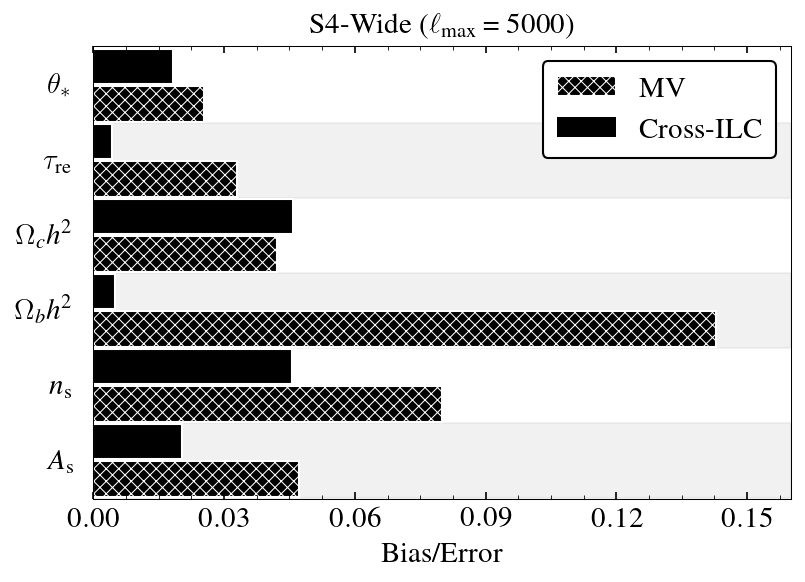

In [198]:
def fn_format_axis(ax,fx,fy):
    for label in ax.get_xticklabels(): label.set_fontsize(fx)
    for label in ax.get_yticklabels(): label.set_fontsize(fy)
    if (0):
        import matplotlib.ticker as ticker
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.xaxis.set_minor_locator(ticker.MaNLocator(4))
        ax.yaxis.set_major_locator(ticker.MaNLocator(4))
        ax.yaxis.set_minor_locator(ticker.MaNLocator(4))
    return ax

exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.5, 'black'], 
                  's4_deep': ['S4-Ultra Deep', 0.03, 'darkred'], 
                  'spt3g': ['SPT-3G', 0.03, 'darkgreen'],
                  'spt4': ['SPT-3G w/ SPT-4', 0.03, 'goldenrod'],
                  'so_baseline': ['SO-Baseline', 0.4, 'royalblue'],
                  'so_baseline_withccatp': ['SO-Baseline w/  FYST', 0.4, 'blue'], 
                  'so_goal': ['SO-Goal', 0.4, 'darkorange'],
                  'so_goal_withccatp': ['SO-Goal w/  FYST', 0.4, 'chocolate'], 
                  }

reqd_lmax_tt_ksz = 5000

close('all')
clf()
fsval = 14
barhwval = 0.5
#fig = figure(figsize = (12., 6.5))
#subplots_adjust(wspace=0.1, hspace=0.3)
#tr, tc = 2, len(bias_dic_for_plotting)/2
exparr_sorted_for_plotting = ['spt3g', 'so_baseline', 'so_goal', 's4_wide', 'spt4', 'so_baseline_withccatp', 'so_goal_withccatp', 's4_deep']
#exparr_sorted_for_plotting = ['so_baseline', 'so_goal', 's4_wide', 'spt4', 'so_baseline_withccatp', 'so_goal_withccatp', 's4_deep']

exparr_sorted_for_plotting = ['s4_wide']

desired_param_name_for_bias_arr = ['As', 'ns', 'ombh2', 'omch2', 'tau', 'thetastar']
xscale_val = None
tr, tc = 1, 1
for expcntr, expname in enumerate( exparr_sorted_for_plotting ):
    ax = subplot(tr, tc, expcntr+1, xscale = xscale_val)
    yloc = 0
    for pcntr, desired_param_name_for_bias in enumerate( desired_param_name_for_bias_arr ):
        for ilcname in bias_dic_for_plotting[expname]:
            tmp_F_mat, tmp_param_names, final_bias_vector, snr_Aksz, sigma_Aksz, sys_sigma_Aksz, Aksz_bias_over_error = bias_dic_for_plotting[expname][ilcname][reqd_lmax_tt_ksz]
            #print(tmp_param_names)
            if (1):
                pind = np.where(tmp_param_names == desired_param_name_for_bias)[0]
                sys_param = final_bias_vector[pind]
                sigma_param = fisher_tools.get_sigma_of_a_parameter(tmp_F_mat, tmp_param_names, desired_param_name_for_bias, prior_dic = prior_dic, fix_params_arr = fix_params_arr)
                bias_over_error = sys_param / sigma_param
                ##print(Aksz_bias_over_error, bias_over_error)
                
            if ilcname == 'MV':
                hatchstyle = 'xxxx'
            else:
                hatchstyle = None
            expname_str, fskyval, colorval = exp_specs_dict[expname]
            barh(yloc+barhwval/2., abs(bias_over_error), color = colorval, height = barhwval*0.95, hatch = hatchstyle, edgecolor = 'white')
            yloc+=barhwval
        #if reqd_lmax_tt_ksz != reqd_lmax_tt_ksz_arr[-1]: axhline(yloc-0.5, lw = 2.)
        if pcntr%2==0:
            axhspan(yloc-(2*barhwval), yloc, color='lightgray', alpha = 0.3, zorder = -1000.)

    #xlab_str = r'%s: Bias/Error ($\frac{\sigma^{\rm sys}}{\sigma^{\rm stat}}$)' %(param_str)
    xlab_str = r'Bias/Error'
    xlabel(xlab_str, fontsize = fsval)
    setp(ax.get_yticklabels(), visible=False); 
    tick_params(axis='y', which='both', left=False, right = False)
    xloc = -0.005
    yloc = 0
    for pcntr, desired_param_name_for_bias in enumerate( desired_param_name_for_bias_arr ):
        param_str = tools_for_plotting.get_latex_param_str(desired_param_name_for_bias)
        for ilcname in bias_dic_for_plotting[expname]:
            if ilcname == 'MV':
                text(xloc, yloc+0.4, r'%s' %(param_str), fontsize = fsval, horizontalalignment = 'right')#, rotation = 20.)
            yloc+=barhwval
    
    title(r'%s ($\ell_{\rm max} = %s$)' %(expname_str, reqd_lmax_tt_ksz), fontsize = fsval)
    ylim(-0.02, yloc+0.02)
    xlim(0., .16)
        
    ax=fn_format_axis(ax,fsval,fsval)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    
if (1): #legend
    xloc, yloc = 0.8, 0.8
    w, h = 0.8, 0.05
    cax = fig.add_axes([xloc, yloc, w, h])
    barh(0., 0., color = 'black', hatch = 'xxxx', edgecolor = 'white', label = r'MV')
    barh(0., 0., color = 'black', hatch = None, label = r'Cross-ILC')
    leg = legend(loc = 1, fontsize=fsval, ncol=1, framealpha = 1., columnspacing=0.5)#, title = r'{\bf ILC:}')
    #leg._legend_box.align ='left'
    #axis('off')
plname = 'plots/cosmo_params_bias_due_to_cibtsz_s4_wide.pdf'
print(plname)
savefig(plname, dpi = 200.)
show()


In [11]:
noiseval_T = 2.
delta_T_radians = noiseval_T * np.radians(1./60.)
delta_P_radians = noiseval_T * np.sqrt(2.) * np.radians(1./60.)
nl_TT = np.tile(delta_T_radians**2., len(els) )
nl_EE = np.tile(delta_T_radians**2., len(els) )
nl_dic = {}
nl_dic['TT'] = nl_TT
nl_dic['EE'] = nl_EE
nl_dic['TE'] = np.copy(nl_TT) * 0.


In [12]:
#check Fisher bias
import tools_for_plotting
params_ini_path = 'publish/data/params_planck_r_0.0_2018_cosmo.txt'
expname = 's4_wide'
pspectra_to_use = ['TT', 'EE', 'TE']
#fix_params = ['mnu', 'ws', 'neff', 'Acibtsz', 'Aksz', 'alpha_radio', 'alpha_radio_sigma']
lmax = 7000
min_l_pol, max_l_pol = 30, 5000 
min_l_temp, max_l_temp = 30, 5000 #5000 #we will set different ell ranges for kSZ. Check max_l_temp_for_ksz_arr below.
prior_dic = {}
prior_dic['tau'] = 0.007

'''
sys_bias_param_name = 'neff'
sys_bias_spectra_arr_to_be_shifted = pspectra_to_use#['TT', 'EE', 'TE']
sys_bias_shift_interms_of_simga = -2. ##1.
'''

#stuff for bias calc.
cl_dic = copy.deepcopy(cl_dic_cmb)
cl_deriv_dic = copy.deepcopy(cl_deriv_dic)
param_names = list(cl_deriv_dic.keys())
    
param_dict = tools_for_plotting.get_ini_param_dict(fpath = params_ini_path)
#print(param_dict[sys_bias_param_name]); #sys.exit()

#get MV polarisation ILC residuals
els = np.arange(lmax)
dl_fac = els * (els+1)/2/np.pi

expname_str, fsky, colorval = exp_specs_dict[expname]
delta_cl_dic = fisher_tools.get_knox_errors_parent(els, cl_dic, nl_dic, fsky)

if (1): #get Fisher matrix first
    F_mat = fisher_tools.get_fisher_matrix(els, cl_deriv_dic, delta_cl_dic, param_names, pspectra_to_use = pspectra_to_use,\
                min_l_temp = min_l_temp, max_l_temp = max_l_temp, min_l_pol = min_l_pol, max_l_pol = max_l_pol)
    
    F_mat_mod = np.copy( F_mat )
    param_names_mod = np.copy( param_names )

(3, 3)
Shifting neff by 0.0029968793405423535
[3.048996879340542]
neff 0.005993758681084707 3.046 508.1953014913101
lensed_scalar
lensed_scalar
dict_keys(['TT', 'EE', 'TE', 'BB'])
Bias vector = [-2.12163370e-03  5.18760136e-06  1.40171916e-05]
param = neff; Fid = 3.046; Shifted = 0.00300; recovered = -0.00212; stat sigma = 0.006, Bias / error = -0.354


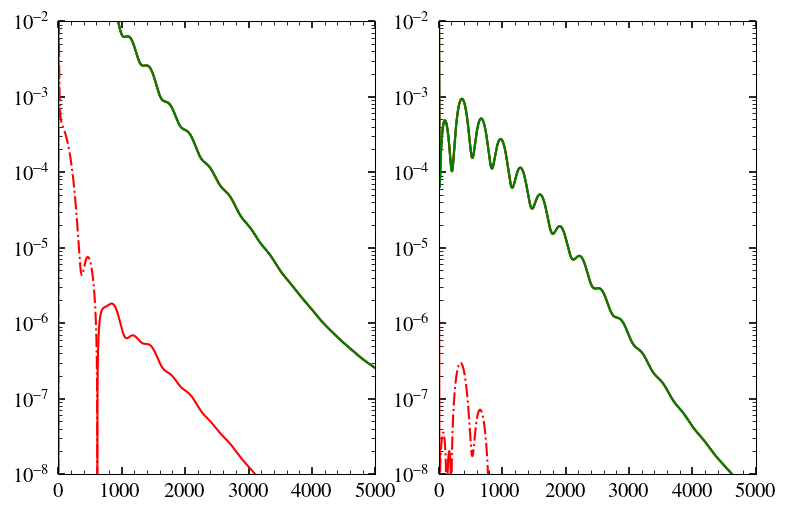

In [14]:
F_mat_mod = np.copy( F_mat )
param_names_mod = np.copy( param_names )

do_not_fix_these_params_arr = ['ombh2','omch2']#, 'As', 'ns', 'tau', 'ombh2']
sys_bias_param_name_arr = ['neff']#, 'omch2']
sys_bias_spectra_arr_to_be_shifted = pspectra_to_use#['TT', 'EE', 'TE']
sys_bias_shift_interms_of_simga = 0.5 #-2. ##1.

fix_params = ['ws', 'mnu']
if (1):
    fix_params = np.copy(param_names).tolist()
    for sys_bias_param_name in sys_bias_param_name_arr:        
        fix_params.remove(sys_bias_param_name)
    for ppp in do_not_fix_these_params_arr:
        fix_params.remove(ppp)


F_mat_mod = fisher_tools.add_priors(F_mat_mod, param_names_mod, prior_dic)
F_mat_mod, param_names_mod = fisher_tools.fix_params(F_mat_mod, param_names_mod, fix_params)
print(F_mat_mod.shape); ##sys.exit()

tmpels, tmpcltt = els, cl_dic['TT']
if (1): #introduce systematic shift
    sys_bias_param_shift_arr = []
    for sys_bias_param_name in sys_bias_param_name_arr:
        stat_sigma = fisher_tools.get_sigma_of_a_parameter(F_mat_mod, param_names_mod, sys_bias_param_name, prior_dic = prior_dic, fix_params_arr = fix_params)
        shift_val = stat_sigma * sys_bias_shift_interms_of_simga
        print('Shifting %s by %s' %(sys_bias_param_name, shift_val))
        ##shift_val = 0.017734987290206894
        sys_bias_param_shift = param_dict[sys_bias_param_name] + shift_val
        sys_bias_param_shift_arr.append( sys_bias_param_shift )
        
    print(sys_bias_param_shift_arr)
    print(sys_bias_param_name, stat_sigma, param_dict[sys_bias_param_name], (param_dict[sys_bias_param_name]/stat_sigma)); #sys.exit()

    els_sys, cl_dic_fid, cl_sys_shift_dic = fisher_tools.simple_fisher_bias_check_introduce_sys_by_changing_cosmo_params(sys_bias_param_name_arr, sys_bias_param_shift_arr = sys_bias_param_shift_arr, sys_bias_spectra_arr_to_be_shifted = sys_bias_spectra_arr_to_be_shifted, fpath = params_ini_path, tmpels = tmpels, tmpcltt = tmpcltt, which_spectra = which_spectra )
    print(cl_dic_fid.keys()); ###sys.exit()
    
    cl_sys_dic = {}
    for which_spec in cl_dic:
        cl_dic_fid[which_spec] = np.interp(els, els_sys, cl_dic_fid[which_spec])
        if which_spec in cl_sys_shift_dic:
            cl_sys_shift = cl_sys_shift_dic[which_spec]
            cl_sys_shift = np.interp(els, els_sys, cl_sys_shift)
            cl_sys_dic[which_spec] = cl_sys_shift

            cl_sys_shift_dic[which_spec] = np.copy(cl_sys_shift)
        else:
            cl_sys_dic[which_spec] = np.zeros_like(cl_dic[which_spec])
            cl_sys_shift_dic[which_spec] = np.zeros_like(cl_dic[which_spec])
            
    ##print(cl_sys_shift_dic.keys()); sys.exit()
if (1): #get modified cl_dic and delta_cl_dic
    cl_dic_mod = {}
    for which_spec in cl_dic:
        if which_spec in cl_sys_dic:
            cl_dic_mod[which_spec] = cl_dic[which_spec] - cl_sys_dic[which_spec]
            #cl_dic_mod[which_spec] = cl_dic_fid[which_spec] - cl_sys_dic[which_spec]
        else:
            cl_dic_mod[which_spec] = cl_dic[which_spec]
            #cl_dic_mod[which_spec] = cl_dic_fid[which_spec]

    delta_cl_dic = fisher_tools.get_knox_errors_parent(els, cl_dic_mod, nl_dic, fsky)
            

final_bias_vector = fisher_tools.get_bias_vector(els, F_mat_mod, param_names_mod, delta_cl_dic, cl_deriv_dic, cl_sys_dic, max_l = max_l_temp, pspectra_to_use = pspectra_to_use)
print('Bias vector = %s' %(final_bias_vector))

for sys_bias_param_name, sys_bias_param_shift in zip(sys_bias_param_name_arr, sys_bias_param_shift_arr):
    pind = np.where(param_names_mod == sys_bias_param_name)
    sys_sigma = final_bias_vector[pind][0]
    stat_sigma = fisher_tools.get_sigma_of_a_parameter(F_mat_mod, param_names_mod, sys_bias_param_name)
    #print(stat_sigma); sys.exit()
    bias_over_error = sys_sigma / stat_sigma
    print('param = %s; Fid = %s; Shifted = %.5f; recovered = %.5f; stat sigma = %.3f, Bias / error = %.3f' 
          %(sys_bias_param_name, param_dict[sys_bias_param_name], 
    sys_bias_param_shift-param_dict[sys_bias_param_name], sys_sigma, stat_sigma, bias_over_error))

if (1):#debug:#reqd_lmax_tt_ksz == 5000:
    close('all')
    clf()
    use_dls = False
    if use_dls:
        dl_fac = els * (els+1)/2/np.pi
    else:
        dl_fac = 1.
    for cntr, which_spec in enumerate( ['TT', 'EE'] ):
        ax = subplot(1,2,cntr+1, yscale='log')
        plot(els, dl_fac * cl_dic[which_spec])
        plot(els, dl_fac * cl_dic_fid[which_spec], color = 'orangered')
        plot(els, dl_fac * cl_dic_mod[which_spec], color = 'green')
        plot(els, dl_fac * cl_sys_dic[which_spec], color = 'red')
        plot(els, dl_fac * -cl_sys_dic[which_spec], color = 'red', ls = '-.')
        axhline(3., lw = 1.)
        if use_dls:
            xlim(0., 5000.); ylim(1e-3, 7e3);
        else:
            xlim(0, 5000); ylim(1e-8, 1e-2); 
    show(); ##sys.exit()


['As', 'mnu', 'ns', 'tau', 'thetastar', 'ws']
3.046
1 neff neff
4 neff ombh2
7 neff omch2
5 ombh2 ombh2
8 ombh2 omch2
9 omch2 omch2
3 3
3.0438783663042788
1 neff neff
4 neff ombh2
7 neff omch2
5 ombh2 ombh2
8 ombh2 omch2
9 omch2 omch2
3 3


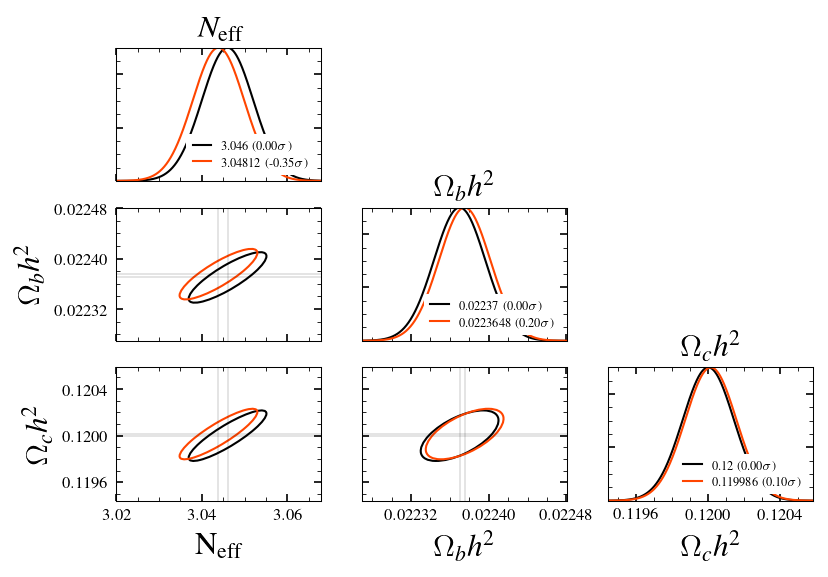

In [15]:
#make a corner plot now
expname_arr = ['fiducial', 'biased']
#desired_params_to_plot = [sys_bias_param_name]
desired_params_to_plot = np.copy(param_names_mod).tolist()
print(fix_params)
for ppp in fix_params:
    if ppp in desired_params_to_plot:
        desired_params_to_plot.remove(ppp)
##desired_params_to_plot = desired_params_to_plot[0:4]
##print(desired_params_to_plot); sys.exit()
color_arr = ['black', 'orangered']
clf()
if len(desired_params_to_plot)>4:
    fig = figure(figsize = (13, 13))
for iter, expname in enumerate( expname_arr ): 
    bias_dic = None
    param_dict_mod = copy.deepcopy( param_dict )
    if iter == 0:
        curr_final_bias_vector = np.zeros_like(final_bias_vector)        
    else:
        curr_final_bias_vector = np.copy(final_bias_vector)
    
    for pind, p in enumerate( param_names_mod ):
        param_dict_mod[p] = param_dict_mod[p] + curr_final_bias_vector[pind]
    bias_dic = {}
    for pind, p in enumerate( param_names_mod ):
        shifted_val = param_dict[p] - curr_final_bias_vector[pind]
        bias_dic[p] = [shifted_val, curr_final_bias_vector[pind]]
    
    
    F_dic = {}
    F_dic[expname] = F_mat_mod

    color_dic = {}
    color_dic[expname] = [color_arr[iter]]
    print(param_dict_mod[sys_bias_param_name])

    tr, tc = tools_for_plotting.make_triangle_plot([expname], F_dic, param_dict_mod, param_names_mod, desired_params_to_plot, color_dic, ls_dic = None, one_or_two_sigma = 1, fsval = 11, prior_dic = prior_dic, bias_dic = bias_dic)
    print(tr, tc)
#show(); sys.exit()

if desired_params_to_plot == [sys_bias_param_name]:
    axvline(param_dict[sys_bias_param_name], color = 'black', ls = '--', label = 'Fiducial: %g' %(param_dict[sys_bias_param_name]))
    xlabel(r'%s' %(tools_for_plotting.get_latex_param_str(sys_bias_param_name)), fontsize = 14)
    legend(loc = 1, fontsize = 8)
    xval = param_dict[sys_bias_param_name]
    x1, x2 = xval - stat_sigma * 10., xval + stat_sigma * 10.
    xlim(x1, x2)
    print(x1, x2)
show()
